# Please install the pip package timm as I have used this for my analysis \
pip install timm

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imsave
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import glob
import sys, os, urllib.request, tarfile, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from typing import Optional, List
from torchvision import models, transforms
import random
import torch
from tqdm.notebook import tqdm

In [2]:
# Enable GPU computing if available
device="cuda"

In [3]:
# This variable is set to false as we already have color images, else this is used to render grayscale images in color
to_color = False

In [4]:
# I have used the efficientnet b3 model as this was the one that fit the memory of my local RTX 2070 GPU 
model_name = 'tf_efficientnet_b3_ns'
# This is the stage of the b3 CNN model from which I am extracting parameters for analysis
level = 7
# This parameter resizes images to the value required by b3 model
RESIZE = 300
# This is the image category variable
target = "wood"

In [5]:
# Set seed values to ensure repeatability of results

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True  

# This is an image transformation function for resizing and normalizing 
    
class ImageTransform():
    def __init__(self, resize=RESIZE):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(resize), 
                transforms.ToTensor(),  
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

# Function to show an image    
    
def fig_show(img):
    plt.imshow(img)
    plt.title("Original")
    plt.show()

    transform = ImageTransform()
    img_transformed = transform(img, phase="train") 
    plt.subplot(1,2,1)
    img_transformed = img_transformed.numpy().transpose((1, 2, 0))
    img_transformed = np.clip(img_transformed, 0, 1)
    plt.imshow(img_transformed*255)
    plt.title("Train")
    plt.show()

set_seed(1213)

In [6]:
# I created a csv file containing the following images that are normal (no anomalies): 
#2021-04-07 21_36_40_exai_rpi_004_51.jpg
#2021-04-07 21_37_18_exai_rpi_001_58.jpg
#2021-04-07 21_39_20_exai_rpi_004_91.jpg

normal_data = pd.read_csv('/home/bharat/Desktop/Extend_AI_Assignment/Normal_Images.csv')
normal_data.head()

,Image_Name
0,2021-04-07 21_36_40_exai_rpi_004_51.jpg
1,2021-04-07 21_37_18_exai_rpi_001_58.jpg
2,2021-04-07 21_39_20_exai_rpi_004_91.jpg


In [7]:
# I created a csv file containing the following images that have anomalies: 
#2021-04-07 21_39_06_exai_rpi_001_85.jpg
#2021-04-07 21_40_10_exai_rpi_001_101.jpg
#2021-04-07 21_43_40_exai_rpi_004_156.jpg

anomaly_data = pd.read_csv('/home/bharat/Desktop/Extend_AI_Assignment/Anomaly_Images.csv')
anomaly_data.head()

,Image_Name
0,2021-04-07 21_39_06_exai_rpi_001_85.jpg
1,2021-04-07 21_40_10_exai_rpi_001_101.jpg
2,2021-04-07 21_43_40_exai_rpi_004_156.jpg
3,2021-04-07 21_39_20_exai_rpi_004_91_normal.jpg


In [8]:
# This is a transformation applied to the training dataset of normal images to augment it and create 400 images 
# 133 of each normal class
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        transforms.RandomHorizontalFlip()],0.7),transforms.RandomApply([transforms.RandomVerticalFlip()],0.7),
		transforms.ToTensor()])

In [9]:
transform_anomaly = transforms.Compose([transforms.Resize((224,224)),
		transforms.ToTensor()])

In [10]:
# Creating a training dataset of 400 images
train_dataset = []
for img_name in tqdm(normal_data['Image_Name']):
    image_path = '/home/bharat/Desktop/Extend_AI_Assignment/imgs/normal/' + img_name
    img = Image.open(image_path)
    for k in range(133):
        transformed_image = transform_train(img)
        train_dataset.append(transformed_image)
    
print(len(train_dataset))     


399


In [11]:
# Creating a dataset of 150 normal images to check the performance of the algorithm
normal_dataset = []
for img_name in tqdm(normal_data['Image_Name']):
    image_path = '/home/bharat/Desktop/Extend_AI_Assignment/imgs/normal/' + img_name
    img = Image.open(image_path)
    for k in range(50):
        transformed_image = transform_train(img)
        normal_dataset.append(transformed_image)

In [12]:
# Creating a dataset of 6 anomalous images to check the performance of the algorithm
anomaly_dataset = []
for img_name in tqdm(anomaly_data['Image_Name']):
    image_path = '/home/bharat/Desktop/Extend_AI_Assignment/imgs/anomaly/' + img_name
    img = Image.open(image_path)
    transformed_image = transform_anomaly(img)
    anomaly_dataset.append(transformed_image)

In [13]:
# Load the efficientnet model and define a function to extract features from level 7 of efficientnet 

import timm
from timm.models.efficientnet import EfficientNet
import torch
import torch.nn.functional as F

def extract_features(inputs: torch.Tensor, 
                     model: EfficientNet,
                     level):
    features = dict()
    # extract stem features as level 1
    x = model.conv_stem(inputs)
    x = model.bn1(x)
    x = model.act1(x)
    features['level_1'] = F.adaptive_avg_pool2d(x, 1)
    # extract blocks features as level 2~8
    for i, block_layer in enumerate(model.blocks):
        x = block_layer(x)
        features[f'level_{i+2}'] = F.adaptive_avg_pool2d(x, 1)
    # extract top features as level
    x = model.conv_head(x)
    x = model.bn2(x)
    x = model.act2(x)
    features['level_9'] = F.adaptive_avg_pool2d(x, 1)
    return features['level_{}'.format(str(level))]

model = timm.create_model(model_name, pretrained=True)
model.eval()
model.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [14]:
# Get the mean and covariance of the features at level 7 of efficientnet - These parameters are the basis of the 
# Gaussian Multivariate model that will distinguish anomalous images
import torch
from sklearn.covariance import LedoitWolf

def get_mean_cov(loader):
    feat = []

    for inputs in loader:
        inputs = inputs.to(device)
        feat_list = extract_features(inputs, model, level) 
        feat_list = feat_list.cpu().detach().numpy()
        
        for i in range(len(feat_list)):
            feat.append(feat_list[i].reshape(-1))

    feat = np.array(feat)
 

    mean = np.mean(feat, axis=0)
    cov = np.cov(feat.T)

    return feat, mean, cov

train_loader = data.DataLoader(train_dataset, 
                               batch_size=1, 
                               shuffle=False, 
                               num_workers=2, 
                               pin_memory=True, 
                               drop_last=True)

normal_loader = data.DataLoader(normal_dataset, 
                                batch_size=1, 
                                shuffle=False, 
                                num_workers=2, 
                                pin_memory=True, 
                                drop_last=True)

anomaly_loader = data.DataLoader(anomaly_dataset, 
                                batch_size=1, 
                                shuffle=False, 
                                num_workers=2, 
                                pin_memory=True, 
                                drop_last=True)

train_feat, mean, cov = get_mean_cov(train_loader)
normal_feat, _, _ = get_mean_cov(normal_loader)
anomaly_feat, _, _ = get_mean_cov(anomaly_loader)

print(mean.shape, cov.shape)

(232,) (232, 232)


In [15]:
# Computing the Mahalanobis distance

from scipy.spatial import distance

def get_score(feat, mean, cov):
    result = []
    cov_i = np.linalg.pinv(cov)

    for i in range(len(feat)):
        result.append(distance.mahalanobis(feat[i], mean, cov_i))
    return result, cov_i

normal_score, cov_i = get_score(normal_feat, mean, cov)
anomaly_score, _ = get_score(anomaly_feat, mean, cov)

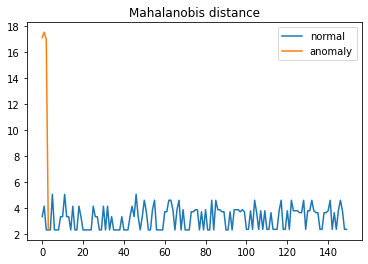

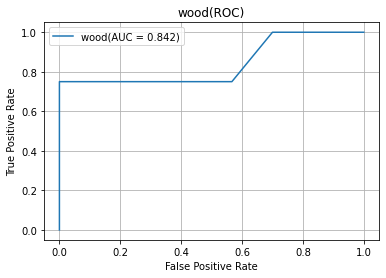

In [16]:
# Plotting the Mahalanobis distance of the normal and anomalous images

import matplotlib.pyplot as plt
from sklearn import metrics

def get_auc(Z1, Z2):
    plt.title("Mahalanobis distance")
    plt.plot(Z1, label="normal")
    plt.plot(Z2, label="anomaly")
    plt.legend()
    plt.show()

    y_true = np.zeros(len(Z1)+len(Z2))
    y_true[len(Z1):] = 1

    # FPR, TPR
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

    # AUC
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc

# Plotting the ROC curve 

def plot_roc(Z1, Z2, name):
    fpr, tpr, auc1 = get_auc(Z1, Z2)
    plt.plot(fpr, tpr, label=name + '(AUC = %.3f)'%(auc1))

    plt.legend()
    plt.title(name + '(ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    return auc1

_ = plot_roc(normal_score, anomaly_score, target)

In [17]:
def get_score_pytorch(feature, mean, cov_i):
    mean = torch.from_numpy(mean).to(device).float()
    cov_i = torch.from_numpy(cov_i).to(device).float()
    result = torch.matmul(feature - mean, cov_i)
    result = torch.matmul(result, feature - mean)
    print("Mahalanobis distance", torch.sqrt(result))
    return torch.sqrt(result)

def make_fig(fig):
    img_mean = [0.485, 0.456, 0.406]
    img_std = [0.229, 0.224, 0.225]
    img = fig.clone().cpu().detach().numpy()
    img = img[0].transpose(1,2,0)
    for i in range(3):
        img[:,:,i] = img[:,:,i]*img_std[i]+img_mean[i]
    return img

In [18]:
alpha = 0.0001
lamda = 1

figures=[]

# get figures

for x_0 in anomaly_loader:
    figures.append(make_fig(x_0))
    
figures.append(make_fig(x_0))

# initial backward
x_0 = x_0.to(device).clone().detach().requires_grad_(True)
feature = extract_features(x_0.to(device), model, level) 
loss = get_score_pytorch(feature.view(-1), mean, cov_i)
loss.backward(retain_graph=True)

x_grad = x_0.grad.data
x_t = x_0 - alpha * x_grad

# backward iteration
for i in range(50):
    feature = extract_features(x_t.to(device), model, level)
    score = get_score_pytorch(feature.view(-1), mean, cov_i)
    loss = score + lamda * torch.abs(x_t - x_0).sum()
    loss.backward(retain_graph=True)

    x_grad = x_0.grad.data
    x_t = x_t - alpha * x_grad
    figures.append(make_fig(x_t))

Mahalanobis distance tensor(2.3510, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.3304, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.2916, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.2389, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.1786, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.1183, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0657, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0270, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0053, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(1.9997, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0056, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0161, device='cuda:0', grad_fn=<SqrtBackward>)
Mahalanobis distance tensor(2.0239, device='cuda:0', grad_fn=<SqrtBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


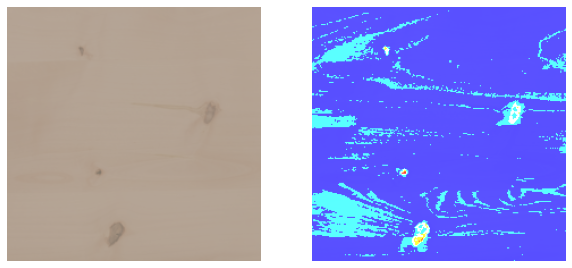

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


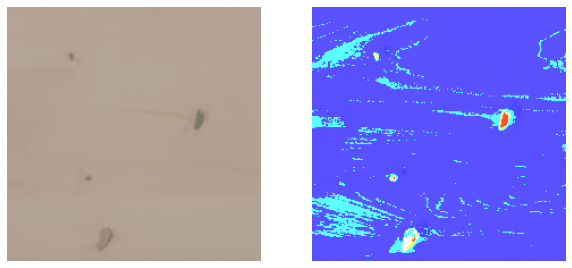

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


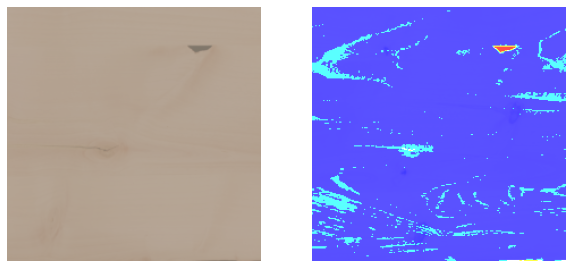

<ipython-input-19-b88ed1406f69>:9: RuntimeWarning: invalid value encountered in true_divide
  diff = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


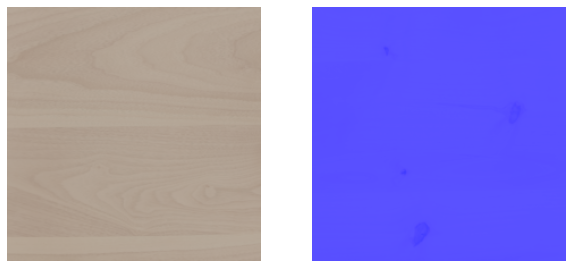

In [19]:
# Displaying the discovered anomalies - the 4th image is a normal image that I have used as reference to 
# compute the contrasts. The first three are the anomalous images.

import cv2

for i in range(len(anomaly_dataset)):

    diff = np.abs(figures[i]-figures[3])
    diff = np.sum(diff, axis=-1)
    diff = (diff-np.min(diff))/(np.max(diff)-np.min(diff))

    jetcam = cv2.applyColorMap(np.uint8(255 * diff), cv2.COLORMAP_JET)  
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  
    jetcam = (np.float32(jetcam) + figures[0] / 2)   
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(figures[i])
  
    plt.subplot(1,2,2)
    plt.imshow(jetcam)
    plt.axis("off")
    plt.show()

## Model Improvement:
### This model can be improved further by using more recent versions of Efficientnet such as b7 that I could ###not use due to GPU limitations. Also, we can apply this to new surfaces by training the CNN on these surfaces and using anomalous images of these surfaces as test sets. The process will be similar to that of wooden surfaces